In [1]:
#imports
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm
import cv2

# Preprocessings d'images

Ci-dessous, nous retrouvons toutes les fonctions de preprocessing d'image, nécessessaires pour les rendre ingérables par nos différents réseaux de neurones. Les fonctions sont issues des différents livrables (Classification, autoencodeur, RNN).

In [2]:
#Preprocess functions
#LIVRABLE 1 --------------------------------------------

def load_image_binary(path):
        try:
            image = tf.io.read_file(path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [400, 400])
            print(type(image))
            return tf.convert_to_tensor(image)
        except tf.errors.InvalidArgumentError:
            print(f" /n Attention : le fichier {path} n'est pas une image valide et sera ignoré.")
            return None
#----------------------------------------------------
#L2
def prepare_denoising(path):
    img = cv2.imread(path)
    img_correct_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_correct_color, (400,400))
    img_normalized = img_resized.astype('float32') / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    return img_batch


#LIVRABLE3 
max_length = 33
attention_features_shape = 64

#inceptionV3---------
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)
#--------------------

def prepare_image_captioning(image):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    #img = tf.image.decode_image(image, channels=3)
    img = tf.image.resize(image, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img






#--------------------------------------------------------------------------

# Chargement des modèles
Ici, on charge les différents modèles que l'on va utiliser

In [3]:
#model loading
#L1------
model_binary = tf.keras.models.load_model('../Livrable_1/models/12_4_2024_14h58.keras')

#L2------
model_denoising_path = "../Livrable_2/best_model/17_4_2024_17h12.keras"
model_denoising = tf.keras.models.load_model(model_denoising_path)

#L3------
captioning_model_path = "./best_model/25_4_2024_22h20"

captioning_encoder = tf.keras.models.load_model(f"{captioning_model_path}/encoder.tf", compile=False) #CHANGEZ ICI

units = 512 # Taille de la couche caché dans le RNN
captioning_decoder = tf.keras.models.load_model(f"{captioning_model_path}/decoder.tf", compile=False) #CHANGEZ ICI

def reset_state(batch_size):
        return tf.zeros((batch_size, units))

# tokenizer loading
with open(f'{captioning_model_path}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


def captioning(image):
    hidden = reset_state(batch_size=1)

    temp_input = tf.expand_dims(prepare_image_captioning(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = captioning_encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = captioning_decoder(dec_input, features, hidden)


        # Reshape predictions to be a 2D matrix of shape [batch_size, vocab_size]
        predictions = tf.reshape(predictions, [1, -1])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result
#----------




# Mise en lien

D:/CESI/A5/datascience/Projet/DataScience/Livrable_3/train2014\COCO_train2014_000000504534.jpg
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 0s 14ms/step
a man posing for a frisbee <end>


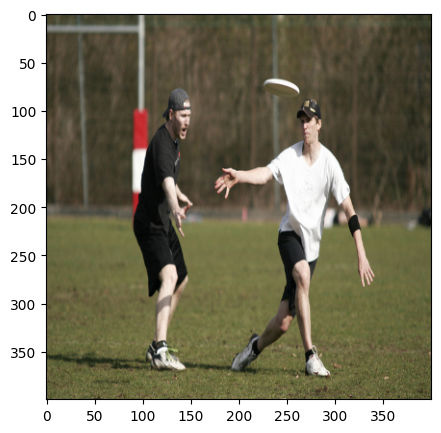

In [12]:
#images_folder = "C:/Users/erwan/Desktop/test_data"
images_folder = "D:/CESI/A5/datascience/Projet/DataScience/Livrable_3/train2014"
fichiers = os.listdir(images_folder)

images = [fichier for fichier in fichiers if fichier.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

imgpath = os.path.join(images_folder, random.choice(images))

print(imgpath)

img = load_image_binary(imgpath)
img = tf.reshape(img, [1,400,400,3])

#print(img)

binary_predict = model_binary.predict(img) #prediction binaire, photo/pas photo

if binary_predict.argmax() == 1: #si notre image est une photo, on passe a la suite

    img = prepare_denoising(imgpath)#preprocessing image for denoising
    denoised_img = model_denoising.predict(img)

    #denoised_img = denoised_img/255.0

    #print(denoised_img.squeeze())

    plt.figure(figsize=(5, 5))
    plt.imshow(img.squeeze())
    caption = ' '.join(captioning(denoised_img*255))
    print(caption)
else:
    print("not a picture")


# Conclusion
Nous avons bien notre modèle qui réalise le captioning désiré. Voici un schéma résumé de la pipêline globale:

![Schéma_pipeline](attachment/schema_pipeline.png)
